# Spectral clustering

Spectral clustering (SC) is a method for matrix factorization and more generally for latent-feature methods in the context of traditional link prediction methods. 

We factorize the observed adjacency matrix of the HCP graph into the product of low-dimensional embeddings and their transpose.

Spectral clustering is meant to serve as a baseline for later comparison with the three GNNs. This latent-feature method does not take node features into account.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import ipynb
from ipynb.fs.defs.helpers import *
import pickle

import json
import os
import time

import networkx as nx

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.manifold import spectral_embedding

## Define helper functions

In [2]:
def get_roc_score(edges_pos, edges_neg, embeddings):
    score_matrix = np.dot(embeddings, embeddings.T)
    
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    # Store positive edge predictions, actual values
    preds_pos = []
    pos = []
    for edge in edges_pos:
        preds_pos.append(sigmoid(score_matrix[edge[0], edge[1]])) # predicted score
        pos.append(adj[edge[0], edge[1]]) # actual value (1 for positive)
        
    # Store negative edge predictions, actual values
    preds_neg = []
    neg = []
    for edge in edges_neg:
        preds_neg.append(sigmoid(score_matrix[edge[0], edge[1]])) # predicted score
        neg.append(adj[edge[0], edge[1]]) # actual value (0 for negative)
        
    # Calculate scores
    preds_all = np.hstack([preds_pos, preds_neg])
    labels_all = np.hstack([np.ones(len(preds_pos)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    return roc_score, ap_score

In [3]:
def mean(dict_values):
    """
    Get mean of dictionary values.
    """
    return np.mean(np.array(list(dict_values)))

In [4]:
def std(dict_values):
    """
    Get standard deviation of dictionary values.
    """
    return np.std(np.array(list(dict_values)))

In [5]:
def filter_best_hyperparameters(df, variable):
    """
    Filter the results data frame for the best hyperparameter combination(s).
    """
    return df[df[variable] == df[variable].max()]

In [6]:
def print_best_hyperparameters(df, variable):
    """
    Print best hyperparameter combination(s).
    """
    df_best = df[df[variable] == df[variable].max()]
    print('The best hyperparameter combination/s is/are:\n\t',
          '\n\t '.join([str(df_best['parameters'].iloc[i]) for i in range(len(df_best))]),
          '\nThe resulting mean validation average precision is:', df_best[variable].unique()[0])

## Creation of graph and adjacency matrix

As preliminary work, we first need to load the links of our original graph, create a networkx graph from them using `nx.Graph()` and calculate the adjacency matrix of this networkx graph, which comes in SciPy sparse format.

In [7]:
# read in all_links
with open('./all_links.txt', 'r') as f:
    all_links = json.loads(f.read())

In [8]:
# create graph and adjacency matrix
g = nx.Graph(all_links)
adj = nx.adjacency_matrix(g)

We now plot the graph to get a better impression of it.

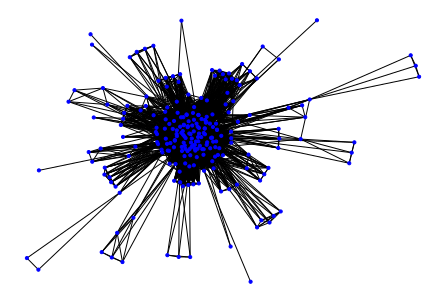

In [9]:
# draw network
np.random.seed(1234)
plt.figure(figsize=(6,4))
graph=nx.draw(g, with_labels=False, node_size=10, node_color='b')

It is evident that one group of HCPs has many connections to other HCPs, while another group of HCPs has only very few connections to other HCPs.

## Training loop

In our training loop, we use the following train-validation-test split: The training set contains a fraction of 0.6 of all 5821 links of our original graph, the validation set contains a fraction of 0.1 of all 5821 links of our original graph and the test set contains a fraction of 0.3 of all 5821 links of our original graph.

The 5821 links referred to above are links that actually exist and can therefore also be called *positive edges*. Links that do not actually exist in a graph are called *negative edges*.

In addition to the positive training, validation and test edges - called `train_edges`, `val_edges` and `test_edges` below, an equal number of negative training, validation and test edges - called `train_edges_false`, `val_edges_false` and `test_edges_false` below - are also extracted. The reason why negative edges are also extracted is that we want to determine not only how reliably the presence of a positive edge is predicted, but also how reliably the absence of a negative edge is predicted.  

We perform 10 runs with different train-validation-test splits, where the respective fractions of 0.6, 0.1 and 0.3 of course always remain unchanged.

The training loop calculates the validation AUCs and APs, test AUCs and APs in the 10 runs as well as the mean validation AUC and AP, mean test AUC and AP, standard deviation of validation AUCs and APs, standard deviation of test AUCs and APs over the 10 runs. We save all results in `sc_results`.

## Hyperparameter tuning

We use the [scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.spectral_embedding.html) `spectral_embedding` to obtain spectral embeddings. With spectral embeddings, the main hyperparameter to tune is:

* `n_components`: dimension of the projection subspace.

There are still other hyperparameters that can be tuned. We do not tune them and instead rely on their default values provided in scikit-learn. We now perform the hyperparameter tuning using a loop.

In [10]:
# Create results folder
route0 = "./results"

if not os.path.exists(route0):
    os.mkdir(route0)

In [12]:
start_time = time.time()

sc_results = pd.DataFrame(columns = ['parameters', 'val_auc', 'val_ap', 'test_auc', 'test_ap', 'mean_val_auc', 'mean_val_ap', 
                                     'mean_test_auc','mean_test_ap', 'std_val_auc', 'std_val_ap', 'std_test_auc', 
                                     'std_test_ap'])

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

# Loop for hyperparameter tuning
for n_components in [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64]:
        
    print(f'====================================================================================================\nParameter combination: {{n_components: {n_components}}}\n====================================================================================================')

    parameter_dict = dict({'n_components': n_components})

    val_auc_dict = dict()
    val_ap_dict = dict()
    test_auc_dict = dict()
    test_ap_dict = dict()

    for i, seed in enumerate(seeds):

        print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

        np.random.seed(seed)

        # Perform train-validation-test split
        adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
            test_edges, test_edges_false = mask_test_edges(adj, test_frac=.3, val_frac=.1)
        g_train = nx.from_scipy_sparse_matrix(adj_train) 

        # Get spectral embeddings
        emb = spectral_embedding(adj_train, n_components = n_components)

        # Calculate AUC and AP for validation and test set
        val_auc, val_ap = get_roc_score(val_edges, val_edges_false, emb)
        test_auc, test_ap = get_roc_score(test_edges, test_edges_false, emb)

        print(f'Validation AUC: {val_auc:.4f}, Validation AP: {val_ap:.4f}, Test AUC: {test_auc:.4f}, Test AP: {test_ap:.4f}')

        val_auc_dict.update({f"{i+1}": val_auc})
        val_ap_dict.update({f"{i+1}": val_ap})    
        test_auc_dict.update({f"{i+1}": test_auc})
        test_ap_dict.update({f"{i+1}": test_ap})   

    data_concat = [{'parameters': parameter_dict, 'val_auc': val_auc_dict, 'val_ap': val_ap_dict, 'test_auc': test_auc_dict, 
                    'test_ap': test_ap_dict, 'mean_val_auc': mean(val_auc_dict.values()), 
                    'mean_val_ap': mean(val_ap_dict.values()), 'mean_test_auc': mean(test_auc_dict.values()), 
                    'mean_test_ap': mean(test_ap_dict.values()), 'std_val_auc': std(val_auc_dict.values()), 
                    'std_val_ap': std(val_ap_dict.values()), 'std_test_auc': std(test_auc_dict.values()), 
                    'std_test_ap': std(test_ap_dict.values())}]
    df_concat = pd.DataFrame(data_concat)
    sc_results = pd.concat([sc_results, df_concat], ignore_index=True)
    
print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to sc_results.pkl")
sc_results.to_pickle(f"{route0}/sc_results.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

Parameter combination: {n_components: 4}
Run 1 with seed 12345:
Validation AUC: 0.4277, Validation AP: 0.4330, Test AUC: 0.4454, Test AP: 0.4395
Run 2 with seed 23456:
Validation AUC: 0.4593, Validation AP: 0.4437, Test AUC: 0.4748, Test AP: 0.4553
Run 3 with seed 34567:
Validation AUC: 0.5024, Validation AP: 0.4567, Test AUC: 0.5164, Test AP: 0.4704
Run 4 with seed 45678:
Validation AUC: 0.4003, Validation AP: 0.4163, Test AUC: 0.4108, Test AP: 0.4207
Run 5 with seed 56789:
Validation AUC: 0.4189, Validation AP: 0.4226, Test AUC: 0.4203, Test AP: 0.4312
Run 6 with seed 54321:
Validation AUC: 0.4124, Validation AP: 0.4352, Test AUC: 0.3947, Test AP: 0.4144
Run 7 with seed 65432:
Validation AUC: 0.4428, Validation AP: 0.4410, Test AUC: 0.4218, Test AP: 0.4331
Run 8 with seed 76543:
Validation AUC: 0.4310, Validation AP: 0.4265, Test AUC: 0.4317, Test AP: 0.4330
Run 9 with seed 87654:
Validation AUC: 0.3916, Validation AP: 0.4069, Test AUC: 0.4168, Test AP: 0.4248
Run 10 with seed 98765:

Validation AUC: 0.7995, Validation AP: 0.7369, Test AUC: 0.7832, Test AP: 0.7133
Run 7 with seed 65432:
Validation AUC: 0.7705, Validation AP: 0.7053, Test AUC: 0.7687, Test AP: 0.6965
Run 8 with seed 76543:
Validation AUC: 0.7844, Validation AP: 0.7030, Test AUC: 0.7567, Test AP: 0.6957
Run 9 with seed 87654:
Validation AUC: 0.7614, Validation AP: 0.6817, Test AUC: 0.7656, Test AP: 0.6890
Run 10 with seed 98765:
Validation AUC: 0.7259, Validation AP: 0.6447, Test AUC: 0.7518, Test AP: 0.6704
Parameter combination: {n_components: 20}
Run 1 with seed 12345:
Validation AUC: 0.7954, Validation AP: 0.7205, Test AUC: 0.7706, Test AP: 0.6957
Run 2 with seed 23456:
Validation AUC: 0.8024, Validation AP: 0.7404, Test AUC: 0.8023, Test AP: 0.7431
Run 3 with seed 34567:
Validation AUC: 0.8187, Validation AP: 0.7653, Test AUC: 0.8176, Test AP: 0.7595
Run 4 with seed 45678:
Validation AUC: 0.8238, Validation AP: 0.7605, Test AUC: 0.7990, Test AP: 0.7370
Run 5 with seed 56789:
Validation AUC: 0.747

Validation AUC: 0.6899, Validation AP: 0.6321, Test AUC: 0.6830, Test AP: 0.6274
Run 3 with seed 34567:
Validation AUC: 0.6934, Validation AP: 0.6441, Test AUC: 0.7100, Test AP: 0.6555
Run 4 with seed 45678:
Validation AUC: 0.7011, Validation AP: 0.6360, Test AUC: 0.6935, Test AP: 0.6384
Run 5 with seed 56789:
Validation AUC: 0.6750, Validation AP: 0.6093, Test AUC: 0.7012, Test AP: 0.6389
Run 6 with seed 54321:
Validation AUC: 0.7148, Validation AP: 0.6593, Test AUC: 0.7057, Test AP: 0.6424
Run 7 with seed 65432:
Validation AUC: 0.6894, Validation AP: 0.6358, Test AUC: 0.6779, Test AP: 0.6201
Run 8 with seed 76543:
Validation AUC: 0.6865, Validation AP: 0.6255, Test AUC: 0.6950, Test AP: 0.6394
Run 9 with seed 87654:
Validation AUC: 0.7025, Validation AP: 0.6447, Test AUC: 0.6899, Test AP: 0.6402
Run 10 with seed 98765:
Validation AUC: 0.6770, Validation AP: 0.6117, Test AUC: 0.7273, Test AP: 0.6770
Parameter combination: {n_components: 36}
Run 1 with seed 12345:
Validation AUC: 0.626

Validation AUC: 0.5761, Validation AP: 0.5433, Test AUC: 0.5509, Test AP: 0.5247
Run 10 with seed 98765:
Validation AUC: 0.5708, Validation AP: 0.5393, Test AUC: 0.5944, Test AP: 0.5601
Parameter combination: {n_components: 48}
Run 1 with seed 12345:
Validation AUC: 0.5235, Validation AP: 0.5064, Test AUC: 0.5391, Test AP: 0.5096
Run 2 with seed 23456:
Validation AUC: 0.5431, Validation AP: 0.5216, Test AUC: 0.5339, Test AP: 0.5089
Run 3 with seed 34567:
Validation AUC: 0.5312, Validation AP: 0.5106, Test AUC: 0.5424, Test AP: 0.5176
Run 4 with seed 45678:
Validation AUC: 0.5371, Validation AP: 0.5203, Test AUC: 0.5257, Test AP: 0.5046
Run 5 with seed 56789:
Validation AUC: 0.5591, Validation AP: 0.5197, Test AUC: 0.5583, Test AP: 0.5191
Run 6 with seed 54321:
Validation AUC: 0.5536, Validation AP: 0.5354, Test AUC: 0.5423, Test AP: 0.5160
Run 7 with seed 65432:
Validation AUC: 0.5291, Validation AP: 0.5101, Test AUC: 0.5463, Test AP: 0.5110
Run 8 with seed 76543:
Validation AUC: 0.540

Validation AUC: 0.4524, Validation AP: 0.4498, Test AUC: 0.4673, Test AP: 0.4626
Run 6 with seed 54321:
Validation AUC: 0.4303, Validation AP: 0.4505, Test AUC: 0.4480, Test AP: 0.4562
Run 7 with seed 65432:
Validation AUC: 0.4627, Validation AP: 0.4643, Test AUC: 0.4647, Test AP: 0.4565
Run 8 with seed 76543:
Validation AUC: 0.4690, Validation AP: 0.4570, Test AUC: 0.4679, Test AP: 0.4634
Run 9 with seed 87654:
Validation AUC: 0.4697, Validation AP: 0.4721, Test AUC: 0.4516, Test AP: 0.4547
Run 10 with seed 98765:
Validation AUC: 0.4376, Validation AP: 0.4523, Test AUC: 0.4475, Test AP: 0.4544
Parameter combination: {n_components: 64}
Run 1 with seed 12345:
Validation AUC: 0.4392, Validation AP: 0.4462, Test AUC: 0.4184, Test AP: 0.4333
Run 2 with seed 23456:
Validation AUC: 0.4212, Validation AP: 0.4340, Test AUC: 0.4128, Test AP: 0.4325
Run 3 with seed 34567:
Validation AUC: 0.4206, Validation AP: 0.4350, Test AUC: 0.4263, Test AP: 0.4424
Run 4 with seed 45678:
Validation AUC: 0.423

In [11]:
# Look at results
sc_results = pd.read_pickle(f"{route0}/sc_results.pkl") 
sc_results

,parameters,val_auc,val_ap,test_auc,test_ap,mean_val_auc,mean_val_ap,mean_test_auc,mean_test_ap,std_val_auc,std_val_ap,std_test_auc,std_test_ap
0,{'n_components': 4},"{'1': 0.42765201166731615, '2': 0.459255913368...","{'1': 0.43298618806671413, '2': 0.443747578829...","{'1': 0.4453524272137656, '2': 0.4747628026226...","{'1': 0.4394654277317551, '2': 0.4552795623298...",0.427937,0.430440,0.437268,0.435621,0.032215,0.013798,0.033521,0.015619
1,{'n_components': 8},"{'1': 0.5848419362076499, '2': 0.6058619997402...","{'1': 0.5328691117509867, '2': 0.5557641358391...","{'1': 0.6214341666568258, '2': 0.5961477650109...","{'1': 0.5569587239735934, '2': 0.5444770304786...",0.598468,0.541659,0.600019,0.542336,0.028403,0.019314,0.020930,0.014658
2,{'n_components': 12},"{'1': 0.686254885983869, '2': 0.72013202489342...","{'1': 0.6053270354139514, '2': 0.6509538030683...","{'1': 0.7024699886764577, '2': 0.7129501698531...","{'1': 0.621792769883111, '2': 0.63836894351624...",0.698785,0.620065,0.692402,0.615896,0.028899,0.026882,0.017258,0.015416
3,{'n_components': 16},"{'1': 0.7631109694028176, '2': 0.7771725652743...","{'1': 0.693642716456907, '2': 0.71127517313056...","{'1': 0.7636902676580999, '2': 0.7750193864818...","{'1': 0.6976701930395193, '2': 0.7099269594282...",0.766814,0.694743,0.765744,0.695035,0.027199,0.030833,0.009014,0.012049
4,{'n_components': 20},"{'1': 0.795390937754632, '2': 0.80241435505012...","{'1': 0.720548702888772, '2': 0.74038585521352...","{'1': 0.7706034673920032, '2': 0.8023457971025...","{'1': 0.6956839710958841, '2': 0.7430711512247...",0.798013,0.734851,0.796610,0.734193,0.023064,0.026714,0.012199,0.015825
5,{'n_components': 24},"{'1': 0.7809455485882312, '2': 0.7635479033077...","{'1': 0.7036448071176199, '2': 0.7036691347050...","{'1': 0.7609243317076244, '2': 0.7650282957347...","{'1': 0.6919453176284545, '2': 0.7004078622633...",0.781343,0.715569,0.775768,0.711173,0.017083,0.018738,0.019568,0.018603
6,{'n_components': 28},"{'1': 0.7445412784449877, '2': 0.7298803745822...","{'1': 0.6784238006431899, '2': 0.6764667471777...","{'1': 0.7290642397809295, '2': 0.7325026340685...","{'1': 0.66832954026841, '2': 0.668866524007154...",0.749275,0.687185,0.742890,0.682146,0.023244,0.024900,0.019606,0.020933
7,{'n_components': 32},"{'1': 0.6964283605531347, '2': 0.6899333971020...","{'1': 0.6369768197172405, '2': 0.6321329036189...","{'1': 0.6880213192254855, '2': 0.6830388949902...","{'1': 0.633870015402985, '2': 0.62740469160486...",0.692615,0.633544,0.697141,0.641320,0.011350,0.014332,0.013729,0.014822
8,{'n_components': 36},"{'1': 0.6267314982109328, '2': 0.6642812437264...","{'1': 0.5861870141079406, '2': 0.6071964638217...","{'1': 0.6579827693212041, '2': 0.6436121706430...","{'1': 0.609326857544638, '2': 0.59450601606194...",0.648723,0.599044,0.652662,0.602806,0.012861,0.008260,0.012557,0.012756
9,{'n_components': 40},"{'1': 0.6063491219990317, '2': 0.6070547112103...","{'1': 0.5643855185066728, '2': 0.5571538446003...","{'1': 0.6229926298566253, '2': 0.6020749112026...","{'1': 0.5755210900986875, '2': 0.5614619275140...",0.605661,0.565288,0.612115,0.568203,0.013092,0.008222,0.010819,0.008272


We can see that the mean AUCs and APs values are nearly the same in the validation and test set. This shows us that the performance observable in the test set is reliable since it is corroborated by the performance in the validation set.

## Best hyperparameter combination

In [12]:
filter_best_hyperparameters(sc_results, 'mean_val_ap')

,parameters,val_auc,val_ap,test_auc,test_ap,mean_val_auc,mean_val_ap,mean_test_auc,mean_test_ap,std_val_auc,std_val_ap,std_test_auc,std_test_ap
4,{'n_components': 20},"{'1': 0.795390937754632, '2': 0.80241435505012...","{'1': 0.720548702888772, '2': 0.74038585521352...","{'1': 0.7706034673920032, '2': 0.8023457971025...","{'1': 0.6956839710958841, '2': 0.7430711512247...",0.798013,0.734851,0.79661,0.734193,0.023064,0.026714,0.012199,0.015825


In [13]:
print_best_hyperparameters(sc_results, 'mean_val_ap')

The best hyperparameter combination/s is/are:
	 {'n_components': 20} 
The resulting validation average precision is: 0.7348505169359163


The best hyperparameter value leads to the highest mean validation AP of 0.7349. 

So, our best hyperparameter value is given by:

* n_components = 20

The mean validation AP is 0.7349 and the mean test AP is 0.7342. The standard deviation of the test APs of 0.0158 is lower than the standard deviation of the validation APs of 0.0267.